In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, ttest_ind, skew, kurtosis, randint
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read file
df = pd.read_csv('water_potability.csv')

## Introduction

**Based on the previous descriptive and inferential analyses of the dataset, it was found that the relationship between individual factors and water potability is not statistically significant. This suggests that the potability may be influenced by a combination of several predictors. Therefore, in the upcoming machine learning analysis, I will use multiple variables as predictors to study their collective impact on potability. Considering the wide range of different variables, I will apply normalization or standardization to ensure that their contributions to the model are balanced.**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
# data preprocessing
# From df.info(), we can see column 'ph', 'Sulfate', 'Trihalomethanes' have null values;
# Fill null values based on their skewness.

# list of cols need to clean
clean_list = ['ph', 'Sulfate', 'Trihalomethanes']

# create a function fill_with() to decide fillna with mean or median.
def fill_with(df, col_name):
    col = df[col_name]
    if abs(skew(col)) < 0.5:
        df[col_name] = col.fillna(col.mean())
    else:
        df[col_name] = col.fillna(col.median())
    return df
    
for col_name in clean_list:
    df = fill_with(df, col_name)

# check whether cleaning is done
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
# define Target Variable and Predictors
y = df['Potability']
X = df.drop('Potability',axis=1)

In [6]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(2620, 9)
(656, 9)


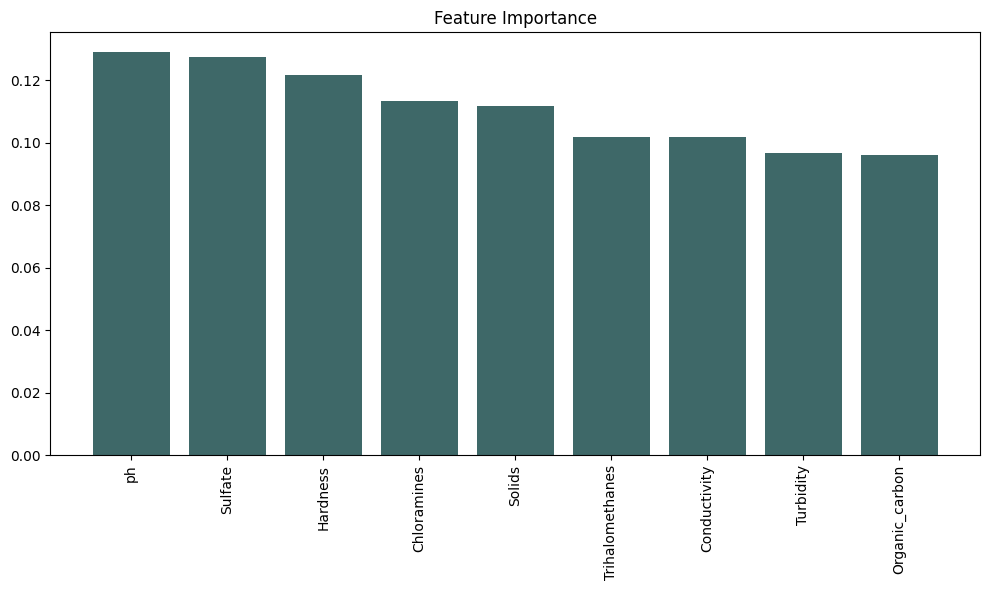

In [7]:
# confirm feature importance

# use random forest to evaluate
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# get importance
importances = model.feature_importances_

# visualizztion
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='#3e6868')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

**From the picture, we can see all features share the similar importance so we are going to use all of them to build a model later.**

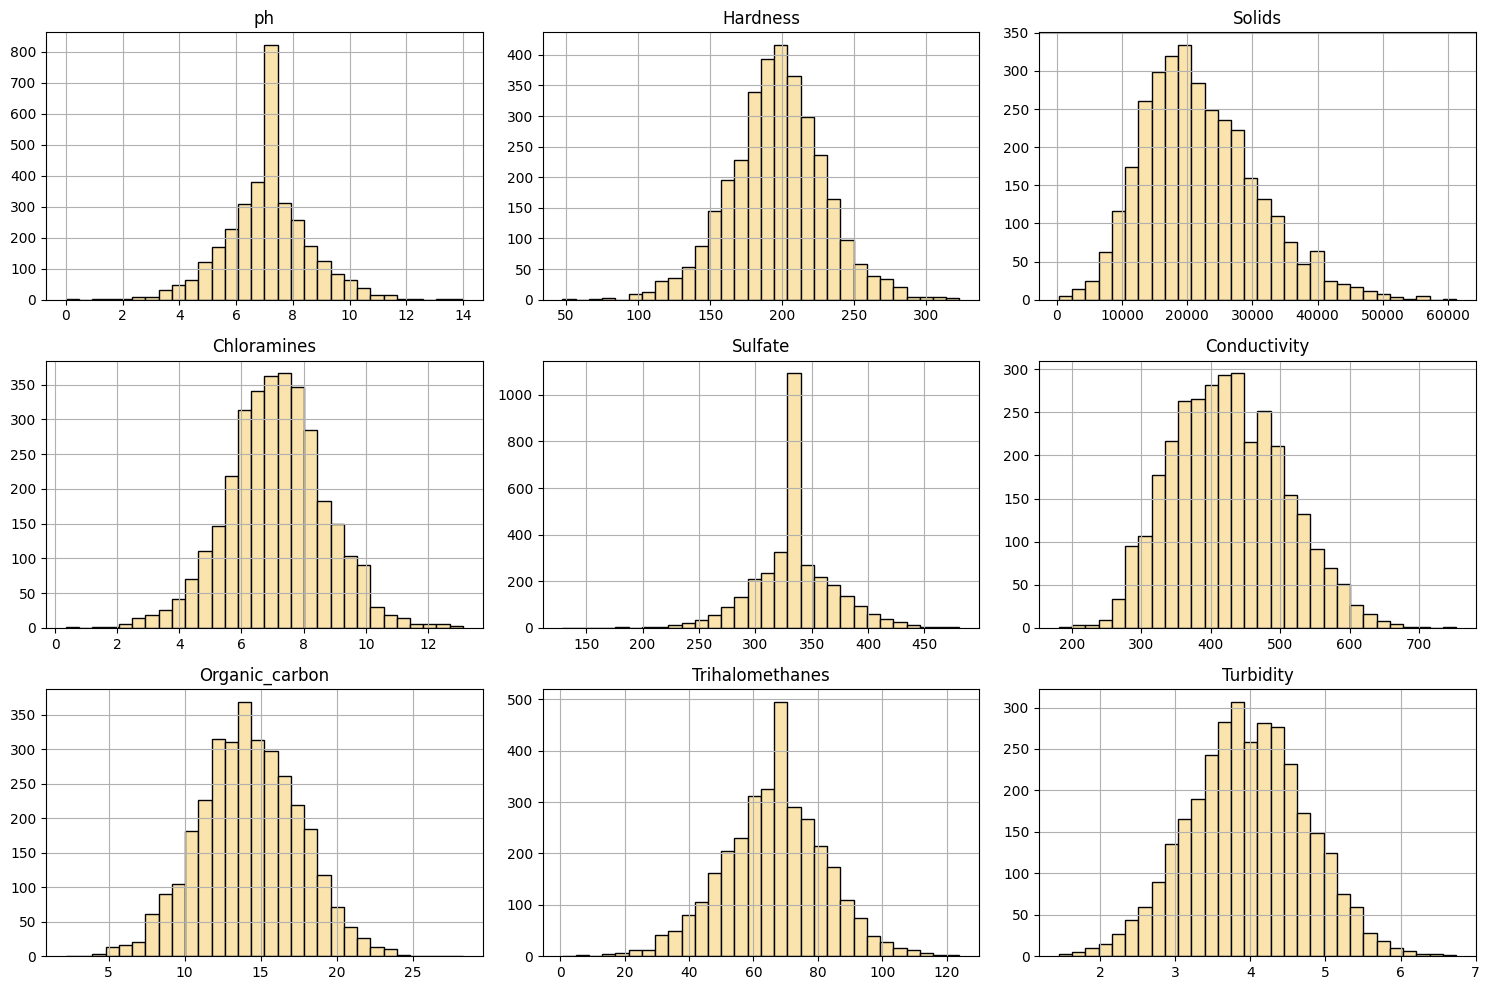

                 Skewness  Kurtosis
ph               0.041248  1.371779
Hardness        -0.039324  0.613001
Solids           0.621350  0.440320
Chloramines     -0.012093  0.587170
Sulfate         -0.027265  1.784113
Conductivity     0.264369 -0.278501
Organic_carbon   0.025521  0.042511
Trihalomethanes -0.087249  0.404829
Turbidity       -0.007813 -0.064536


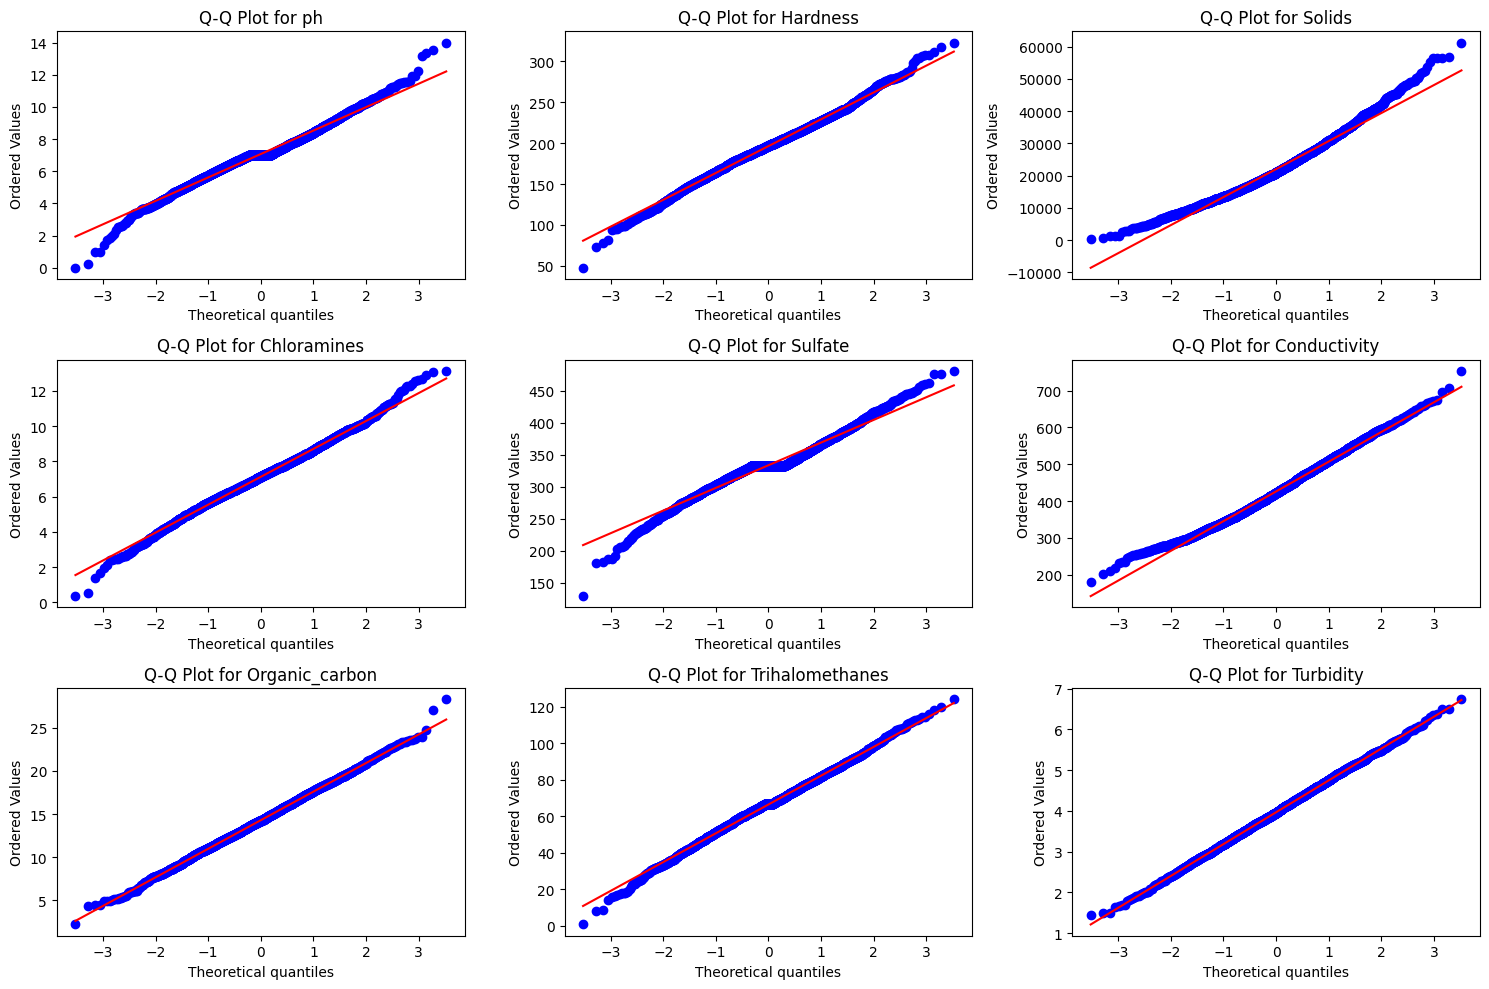

In [8]:
# visualize features to decide to use which scaling techniques 

# plot histograms
X.hist(bins=30, figsize=(15, 10), color='#FAE3AC', edgecolor='black')
plt.tight_layout()
plt.show()

# calculate skewness and kurtosis of all features
skewness = X.apply(lambda x: skew(x))
kurtosis_values = X.apply(lambda x: kurtosis(x))
summary_stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis_values})
print(summary_stats)

# QQ plot
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)  
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')
plt.tight_layout()
plt.show()

**Based on the charts, most of the features exhibit distributions that are close to normal, making standardization a suitable data processing method.**

In [10]:
def evaluate_model(X_train, y_train, X_test, y_test, model, use_scaler=True):
    """
    evaluate model performance and return classification report
    
    Parameters:
    X_train, y_train : trained data
    X_test, y_test : tested data
    model : model need to be evaluated (such as LogisticRegression(), RandomForestClassifier())
    use_scaler : whether need standardization (True or False)
    
    Returns:
    report_str (str) : classification report in string format
    report_dict (dict) : classification report in dictionary format
    """
    if use_scaler:
        # create pipeline including standardization and model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        # train Pipeline
        pipeline.fit(X_train, y_train)
        # predict
        y_pred = pipeline.predict(X_test)
    else:
        # train the model
        model.fit(X_train, y_train)
        # predict
        y_pred = model.predict(X_test)
    
    # generate classification report in both string and dictionary formats
    report_str = classification_report(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    return report_str, report_dict

# Evaluating models and extracting reports
log_reg_report_str, log_reg_report_dict = evaluate_model(X_train, y_train, X_test, y_test, LogisticRegression(), use_scaler=True)
rf_report_str, rf_report_dict = evaluate_model(X_train, y_train, X_test, y_test, RandomForestClassifier(), use_scaler=False)
svm_report_str, svm_report_dict = evaluate_model(X_train, y_train, X_test, y_test, SVC(), use_scaler=True)
knn_report_str, knn_report_dict = evaluate_model(X_train, y_train, X_test, y_test, KNeighborsClassifier(), use_scaler=True)
nb_report_str, nb_report_dict = evaluate_model(X_train, y_train, X_test, y_test, GaussianNB(), use_scaler=False)
gbm_report_str, gbm_report_dict = evaluate_model(X_train, y_train, X_test, y_test, GradientBoostingClassifier(), use_scaler=False)

# Printing the classification reports
print("Logistic Regression Report:\n", log_reg_report_str)
print("Random Forest Report:\n", rf_report_str)
print("Support Vector Machine Report:\n", svm_report_str)
print("K-Nearest Neighbors Report:\n", knn_report_str)
print("Naive Bayes Report:\n", nb_report_str)
print("Gradient Boosting Machine Report:\n", gbm_report_str)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656

Random Forest Report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78       412
           1       0.66      0.37      0.48       244

    accuracy                           0.70       656
   macro avg       0.68      0.63      0.63       656
weighted avg       0.69      0.70      0.67       656

Support Vector Machine Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.79       412
           1       0.70      0.27      0.39       244

    accuracy                           0.69       656
   macro avg       0.69      0.60      0.59 

In [24]:
# compare accuracy from different models
# Extracting accuracy from the reports
accuracy_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 
              'K-Nearest Neighbors', 'Naive Bayes', 'Gradient Boosting Machine'],
    'Accuracy': [
        log_reg_report_dict['accuracy'], 
        rf_report_dict['accuracy'], 
        svm_report_dict['accuracy'], 
        knn_report_dict['accuracy'], 
        nb_report_dict['accuracy'], 
        gbm_report_dict['accuracy']
    ]
}

# Creating DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Displaying the DataFrame
print(accuracy_df)

                       Model  Accuracy
0        Logistic Regression  0.628049
1              Random Forest  0.696646
2     Support Vector Machine  0.685976
3        K-Nearest Neighbors  0.631098
4                Naive Bayes  0.615854
5  Gradient Boosting Machine  0.685976


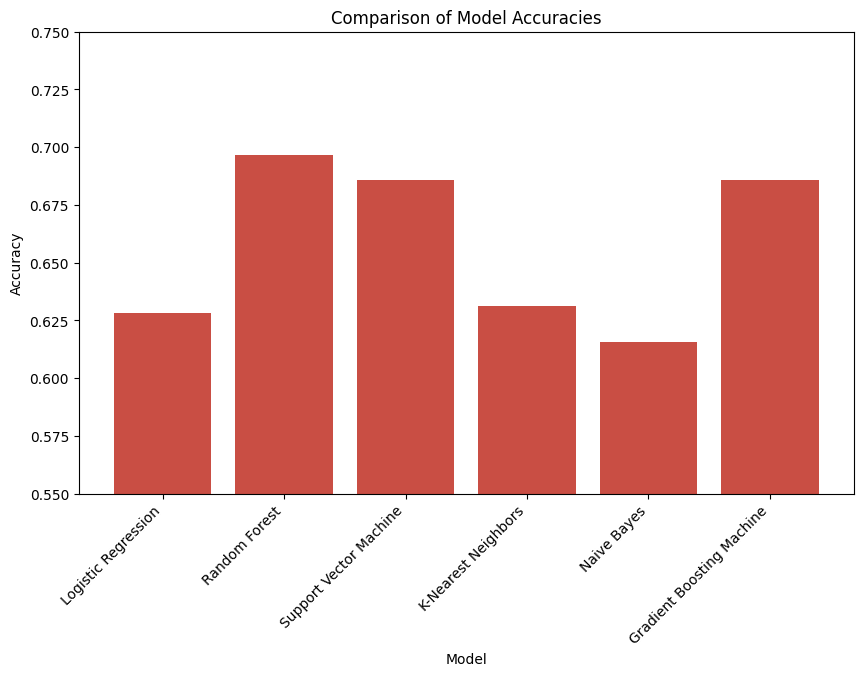

In [33]:
# Plotting the accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color='#C94E44')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.55, 0.75)  
plt.xticks(rotation=45, ha='right')
plt.show() 

**The accuracy of all models ranges between 0.63 and 0.69; however, their recall is quite low, indicating issues with recognizing the minority class. Overall, Logistic Regression performed the worst, particularly with almost no ability to recognize class 1(Potable). Random Forest, Support Vector Machine (SVM) and Gradient Boosting Machine performed relatively better, but they still favor the majority class. KNN and Naive Bayes exhibited similar trends but did not significantly outperform Random Forest, SVM and Gradient Boosting Machine.**

In [9]:
# Based on the classification report results of all six models, SMOTE will be used next to balance the data.  
sm = SMOTE(random_state=0)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"Original X shape: {X.shape}")
print(f"Resampled X shape: {X_resampled.shape}")

Original X shape: (3276, 9)
Resampled X shape: (3172, 9)


In [11]:
# evaluate with resampled training data  
rf_report_smote_str, rf_report_smote_dict  = evaluate_model(X_resampled, y_resampled, X_test, y_test, RandomForestClassifier(), use_scaler=False)
svm_report_smote_str, svm_report_smote_dict = evaluate_model(X_resampled, y_resampled, X_test, y_test, SVC(), use_scaler=True)
gbm_report_smote_str, gbm_report_smote_dict = evaluate_model(X_resampled, y_resampled, X_test, y_test, GradientBoostingClassifier(), use_scaler=False)

print("Random Forest Report after SMOTE:\n", rf_report_smote_str)
print("Support Vector Machine after SMOTE:\n", svm_report_smote_str)
print("Gradient Boosting Machine after SMOTE:\n", gbm_report_smote_str)

Random Forest Report after SMOTE:
               precision    recall  f1-score   support

           0       0.71      0.76      0.74       412
           1       0.54      0.47      0.50       244

    accuracy                           0.66       656
   macro avg       0.63      0.62      0.62       656
weighted avg       0.65      0.66      0.65       656

Support Vector Machine after SMOTE:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70       412
           1       0.50      0.54      0.52       244

    accuracy                           0.63       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.64      0.63      0.63       656

Gradient Boosting Machine after SMOTE:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69       412
           1       0.49      0.52      0.51       244

    accuracy                           0.62       656
   macro avg    

In [24]:
# compare accuracy from selected models
# Extracting accuracy from the reports
accuracy_data = {
    'Model': ['Random Forest', 'Support Vector Machine', 'Gradient Boosting Machine'],
    'Accuracy': [
        rf_report_smote_dict['accuracy'], 
        svm_report_smote_dict['accuracy'], 
        gbm_report_smote_dict['accuracy']
    ]
}

# Creating DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Displaying the DataFrame
print(accuracy_df)

                       Model  Accuracy
0              Random Forest  0.660061
1     Support Vector Machine  0.629573
2  Gradient Boosting Machine  0.623476


**Despite SMOTE balancing the dataset, the improvement in the model's ability to handle class imbalance is limited, particularly in recognizing class 1(Potable). This could be because the features of class 0(Non-potable) still dominate the dataset, leading the models to favor predicting the majority class. SVM and Random Forest performed relatively better, but even within these models, the recall for class 1(Potable) did not reach an ideal level.**

In [42]:
# SVM, Random Forest and GradientBoosting performed relatively better among all the models, indicating that they might have more potential given the current data and problem. 
# Will use Grid Search and cross validation to tune the hyperparameters of these selected models.

def grid_search_cv(model, param_grid, X_train, y_train, X_test, y_test, cv=5, scoring='accuracy', use_scaler=False):
    """
    excute grid search and cross validation, return best model and classification report.

    parameters:
    - model: models need to be tuned (e.g. RandomForestClassifier())。
    - param_grid: hyperparameter grid (e.g. {'n_estimators': [50, 100], 'max_depth': [None, 10]}.
    - X_train, y_train: training data.
    - X_test, y_test: testing data.
    - cv: folds of cross validation (default is 5).
    - scoring: evaluate satndard (default is 'accuracy').
    - use_scaler: whether use scaler (default is 'False').

    return:
    - best_model: model tuned by best hyperparameters.
    - report: classification report on testing data.
    """
    
    #if neen standardization, will apply standardscaler to pipeline:
    if use_scaler:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('classifier', model)
        ])
        
    # excute grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # get best model
    best_model = grid_search.best_estimator_
    
    # predict on testing data
    y_pred = best_model.predict(X_test)
    
    # return classification report
    report = classification_report(y_test, y_pred)
    
    # output the result
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-validation Score:", grid_search.best_score_)
    
    return best_model, report

In [43]:
# ecaluate on three choosen models
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
model = RandomForestClassifier(random_state=0)
best_model, rf_report = grid_search_cv(model, param_grid_rf, X_resampled, y_resampled, X_test, y_test, use_scaler=False)
print('rf_report_tuned:')
print(rf_report)
 
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
model = SVC(random_state=0)
best_model, svm_report = grid_search_cv(model, param_grid_svm, X_resampled, y_resampled, X_test, y_test, use_scaler=True)
print('svm_report_tuned:')
print(svm_report)

param_grid_gbm = {
    'n_estimators': [100, 200, 300],       
    'learning_rate': [0.01, 0.1, 0.2],     
    'max_depth': [3, 4, 5],              
    'min_samples_split': [2, 5, 10]    
}
gbm_model = GradientBoostingClassifier(random_state=0)
best_model, gbm__report = grid_search_cv(model, param_grid_svm, X_resampled, y_resampled, X_test, y_test, use_scaler=False)
print('gbm_report_tuned:')
print(gbm_report)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Score: 0.6948528279390944
rf_report_tuned:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       412
           1       0.53      0.48      0.50       244

    accuracy                           0.65       656
   macro avg       0.62      0.61      0.62       656
weighted avg       0.64      0.65      0.64       656

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-validation Score: 0.5542358230457787
svm_report_tuned:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-

**Performance of Random Forest**:
The tuned Random Forest model performed slightly better than untuned one. Although the performance on potable water samples (Class 1) still has room for improvement, overall, this model is more balanced than the SVM and is suitable for further optimization.

**Performance of Support Vector Machine (SVM)**:
The tuned SVM's performance is even worse than untuned one, especially in Class 1(Potable), where it completely fails. While it performs exceptionally well in identifying non-potable water samples (achieving a recall of 1.00), it almost entirely ignores potable water samples, making this model impractical for real-world application.

**Performance of Gradient Boosting Machine (GBM)**:
The tuned GBM's performance is very similar to the previous one.

**Will focus on using random forest to keep training model**

In [13]:
# Try use randon search combined with grid search on random forest model

# initiate random forest classifier
rf = RandomForestClassifier(random_state=42)

# define hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),           # number of tress
    'max_features': ['auto', 'sqrt', 'log2'],   
    'max_depth': [None, 10, 20, 30, 40, 50],   
    'min_samples_split': randint(2, 11),        
    'min_samples_leaf': randint(1, 5),          
    'bootstrap': [True, False]                  # whether use boostrap to sample
}
# initiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='accuracy')

# perform random search on resampled training data
random_search.fit(X_resampled, y_resampled)

# output best parameters 
print(f"Best parameters found: {random_search.best_params_}")

# output accuracy of best parameters
best_model = random_search.best_estimator_
print(f"Best training accuracy: {random_search.best_score_}")

# predict
y_pred_resampled = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_resampled))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=166; total time=   3.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=166; total time=   3.9s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=71; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=135; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=96; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=193; total time=   3.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=82; tot

In [ ]:
'''
Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 177}
Best training accuracy: 0.6995831987878487
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.73       412
           1       0.54      0.50      0.52       244

    accuracy                           0.66       656
   macro avg       0.63      0.63      0.63       656
weighted avg       0.65      0.66      0.66       656
'''

In [14]:
# define gridsearch based on random search result
param_grid = {
    'n_estimators': [160, 170, 180, 190, 200],                
    'max_features': ['log2'],                        
    'max_depth': [None],                             
    'min_samples_split': [2, 3, 4, 5],             
    'min_samples_leaf': [1, 2, 3],                 
    'bootstrap': [False]                            

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_resampled, y_resampled)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
print(f"Best training accuracy: {grid_search.best_score_}")

y_pred_resampled = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_resampled))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=160; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=170; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=190; total time=   3.8s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=190; total time=   4.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_

In [ ]:
'''
Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 160}
Best training accuracy: 0.7008425445242059
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       412
           1       0.54      0.50      0.52       244

    accuracy                           0.65       656
   macro avg       0.63      0.62      0.62       656
weighted avg       0.65      0.65      0.65       656
'''

**Both recall and f1-score improved 0.01, accuracy decreased by 0.01.**

In [11]:
# redo random forest use more parameters(add class_weight='balanced') on imbalanced training data
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# output the result
print("Best Parameters:", grid_search.best_params_)

# use best parameters to predict
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# output result
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  12.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.7s
[CV] END max_depth=10, min_

In [ ]:
'''
                precision    recall  f1-score   support

           0       0.70      0.89      0.78       412
           1       0.66      0.35      0.46       244

    accuracy                           0.69       656
   macro avg       0.69      0.62      0.62       656
weighted avg       0.69      0.69      0.66       656
'''

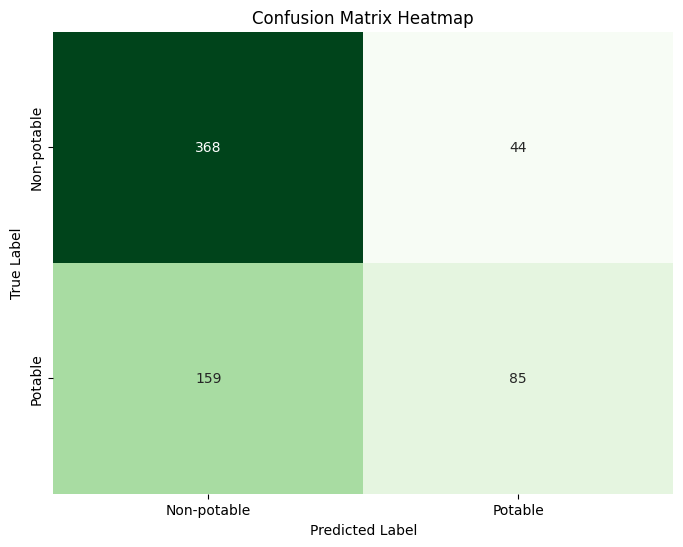

In [12]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# use heatmap visualize confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Non-potable', 'Potable'], 
            yticklabels=['Non-potable', 'Potable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

**Overall accuracy imporved from 0.65 to 0.69 but recall on class 1 decreased.**

RandomForestClassifier(n_estimators=10, random_state=0)
AUC for 10 estimators: 0.6231696641731657
-------------------------------------------------------
RandomForestClassifier(n_estimators=50, random_state=0)
AUC for 50 estimators: 0.6579112287123985
-------------------------------------------------------
RandomForestClassifier(random_state=0)
AUC for 100 estimators: 0.6665456390259431
-------------------------------------------------------
RandomForestClassifier(n_estimators=200, random_state=0)
AUC for 200 estimators: 0.6694751710966099
-------------------------------------------------------
RandomForestClassifier(n_estimators=500, random_state=0)
AUC for 500 estimators: 0.6774928378163297
-------------------------------------------------------
RandomForestClassifier(n_estimators=1000, random_state=0)
AUC for 1000 estimators: 0.6792933312112048
-------------------------------------------------------


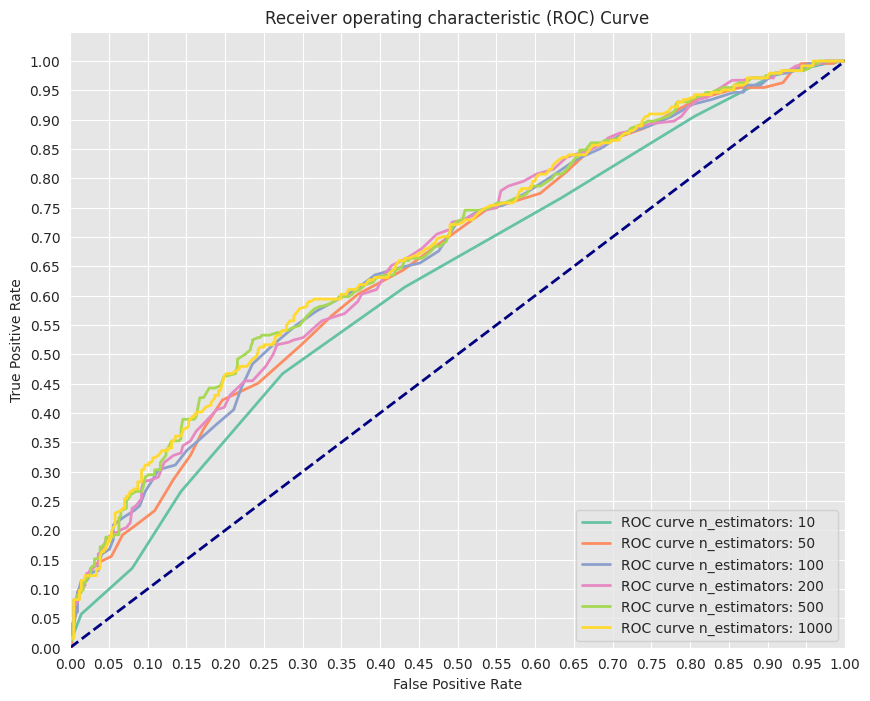

In [53]:
# plot roc curve
n_estimators_range = [10, 50, 100, 200, 500, 1000]
names = [str(n) for n in n_estimators_range]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, estimators in enumerate(n_estimators_range):
    # Fit a model
    rf = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model_rf = rf.fit(X_resampled, y_resampled)
    print(model_rf)  # Preview model params

    # Predict
    y_score = rf.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {} estimators: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve n_estimators: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**When n_estimators = 200, auc score is the best.**

In [69]:
# try interaction to improve model performance

# choose features based on previous feature importance plot
important_features = ['ph', 'Sulfate', 'Hardness', 'Chloramines']

# generate interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# generate interaction for training data
X_resampled_important = X_resampled[important_features]
X_resampled_interactions = poly.fit_transform(X_resampled_important)

# generate interaction for testing data
X_test_important = X_test[important_features]
X_test_interactions = poly.transform(X_test_important) 

# combine interacted features with other features
X_resampled_combined = np.hstack((X_resampled_interactions, X_resampled.drop(columns=important_features).values))
X_test_combined = np.hstack((X_test_interactions, X_test.drop(columns=important_features).values))

# use combined feature to oredict
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled_combined, y_resampled)
y_pred = rf.predict(X_test_combined)

# output the result
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       412
           1       0.53      0.48      0.50       244

    accuracy                           0.65       656
   macro avg       0.62      0.61      0.61       656
weighted avg       0.64      0.65      0.64       656



**The model doesn't improve.**

In [70]:
# simplify model and retrain the model on resampled data
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min

In [ ]:
'''
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       412
           1       0.55      0.48      0.51       244

    accuracy                           0.66       656
   macro avg       0.63      0.62      0.63       656
weighted avg       0.65      0.66      0.66       656
'''

In [7]:
# try to improve model performance using Stacking

# define Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]

# define Meta model
meta_model = LogisticRegression()

In [8]:
# initiate Stacking model
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# train Stacking model
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression())

In [9]:
# use trained Stacking model to predict
y_pred = stacking_clf.predict(X_test)

# output classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       412
           1       0.68      0.34      0.45       244

    accuracy                           0.69       656
   macro avg       0.69      0.62      0.62       656
weighted avg       0.69      0.69      0.66       656



In [12]:
# try using resampled data repeat previous steps
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_clf.fit(X_resampled, y_resampled)
y_pred_resampled = stacking_clf.predict(X_test)
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       412
           1       0.51      0.43      0.47       244

    accuracy                           0.64       656
   macro avg       0.60      0.59      0.60       656
weighted avg       0.63      0.64      0.63       656



**After experimenting with stacking, I found that the model's performance using the original training data was better compared to the resampled data. However, the accuracy still did not exceed 0.69. There was a slight improvement in the recall and f1-score for class 1(Potable), with both metrics increasing by 0.01. Therefore, the stacking model using imbanlanced training data will be taken as the final result.**

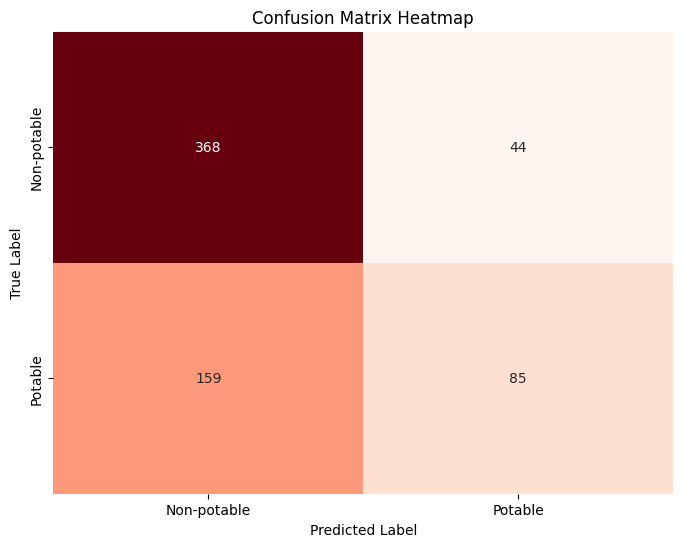

In [17]:
# calculate confusion matrix of first stacking data
cm = confusion_matrix(y_test, y_pred)

# use heatmap visualize confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=['Non-potable', 'Potable'], 
            yticklabels=['Non-potable', 'Potable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

**According to the confusion matrix, it identifies non-potable water (Class 0) with a high recall of 0.91 and a precision of 0.70, resulting in only 39 false positives. For potable water (Class 1), the model achieves a recall of 0.34 and a precision of 0.68. Overall, the model provides a balanced performance, particularly excelling in minimizing the misclassification of non-potable water.**

### Project Summary 


**Data Preprocessing:**
During data preprocessing, missing values were imputed using the median or mode based on the observation of skewness. This step ensured data integrity and reduced bias caused by missing data.

**Model Development:**
1. **Initial Feature and Target Analysis:**
   Defined the input variables X (all features) and the output variable y (potability), and split the dataset into training and testing sets. A preliminary analysis of feature importance using a random forest model showed that all features contributed similarly, with importance ranging from 10% to 15%.

2. **Data Standardization:**
   Histograms, skewness, kurtosis, and QQ plots were used to analyze data distribution, leading to the decision to standardize the data to improve model performance.

3. **Model Selection and Evaluation:**
   Evaluation functions were defined, and classification reports were generated for various models, including Logistic Regression, Random Forest, Support Vector Machine (SVM), KNN, Naive Bayes, and Gradient Boosting Machine (GBM). Random Forest, SVM, and GBM performed the best. Data-sensitive models were further optimized using pipelines combined with standardization.

4. **Data Balancing and Parameter Tuning:**
   SMOTE was applied to balance the data, and the top three models were retrained using grid search to find the best parameters. The Random Forest model performed the best.

5. **Further Optimization and Evaluation:**
   The Random Forest model was retrained on the original unbalanced dataset with the addition of the `class_weight='balanced'` parameter, resulting in the best accuracy of 0.69. Confusion matrices and ROC curves were plotted, but no further improvement was observed.

6. **Feature Engineering and Model Retraining:**
   Based on feature importance data, four key features were selected and interactions were created, but the model performance did not exceed the 0.69 accuracy threshold. The Random Forest model was retrained on the resampled data with a broader parameter range, and the LGBM classifier was introduced, but no significant improvement was achieved.

7. **Stacking Model and Final Selection:**
To further improve model performance, stacking was applied using Random Forest, Gradient Boosting, Support Vector Machine, and KNN as base models, with Logistic Regression as the meta-model. Both the original and resampled training datasets were used for training. The original training set resulted in the same best accuracy of 0.69 as before, but with a 0.01 improvement in recall and f1-score for Class 1(Potable). Consequently, this model was selected as the final result.

**Final Result:**
The model with 0.69 accuracy was selected as the final model, selected due to the improved performance in Class 1(Potable) metrics, was based on the original training data, enhanced by stacking.

**Conclusion and Improvement Suggestions:**

**Conclusion:**
Throughout the experimental process, multiple models and methods were applied to analyze and optimize the data. Various techniques, including feature engineering, data balancing, and hyperparameter tuning, and model ensembling with stacking, were explored to improve model performance. The final model achieved an accuracy of 0.69 with a slight improvement in Class 1(Potable) recall and f1-score, making it the chosen model despite no significant breakthroughs in overall accuracy.

**Improvement Suggestions:**
1. **Feature Selection and Engineering:** While feature engineering based on importance has been attempted, further exploration of non-linear feature combinations or dimensionality reduction techniques such as PCA or LDA could reduce the impact of noise.

2. **Model Ensembling:** Consider ensemble methods like Bagging, Boosting to potentially enhance model performance, building on the success observed with Stacking.

3. **Advanced Data Augmentation:** Beyond SMOTE, more complex generative models like GANs could be used to generate synthetic data, potentially improving model training.

4. **Model Interpretability and Business Application:** Further analysis of model interpretability, particularly from a business perspective, can identify key features critical to predicting potability. This not only aids in model optimization but also provides valuable insights for real-world business applications.

**Business Application:**
Despite the model's accuracy of 0.69, it can still be used for preliminary screening of water potability. Given the model's interpretability, it is advisable to take a conservative approach to predictions in actual business scenarios and combine results with other external data and expert judgment for a comprehensive evaluation.